In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats as stats
from scipy.stats import randint

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 1600)
pd.set_option('display.max_rows', 1600)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold

from sklearn.metrics import r2_score, mean_squared_error, make_scorer

In [98]:
df = pd.read_csv("Mercedes.csv")

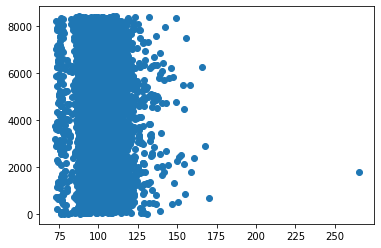

In [99]:
plt.scatter(df['y'], df['ID'])

In [100]:
df = df[df['y']<150]

In [101]:
# Colum names, Missing values count, Missing values percentage in DataFrame
missing_val_df = pd.DataFrame({
    'name': df.columns,
    'mcount': df.isna().sum(),
    'mpercentage': df.isnull().sum()/df.shape[0]*100
})

#missing_val_df.to_csv("missing_values.csv", index=False)
#missing_val_df.sort_values(by='mpercentage', ascending=False)

In [102]:
y = df.iloc[:,1]

In [103]:
y = np.log(y)

In [104]:
X = df.iloc[:, 2:]

In [105]:
X.shape

(4194, 376)

In [106]:
uniqeCol = []
for col in X.columns:
    if X[col].nunique() == 1:
        uniqeCol.append(col)
        X.drop(columns=col, inplace=True)
print(len(uniqeCol))

13


In [107]:
X.shape

(4194, 363)

In [108]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4194 entries, 0 to 4208
Columns: 363 entries, X0 to X385
dtypes: int64(355), object(8)
memory usage: 11.6+ MB


In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [110]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3355 entries, 2745 to 863
Columns: 363 entries, X0 to X385
dtypes: int64(355), object(8)
memory usage: 9.3+ MB


In [111]:
class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [112]:
Le = LabelEncoderExt()

In [113]:
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        Le.fit(X_train[col])
        X_train[col] = Le.transform(X_train[col])
        X_test[col] = Le.transform(X_test[col])

In [114]:
# perform PCA
pca = PCA()
X_train_pca_df = pd.DataFrame(pca.fit_transform(X_train))

In [115]:
#pca.explained_variance_
#pca.explained_variance_ratio_

Text(0, 0.5, 'Explained veriance ratio')

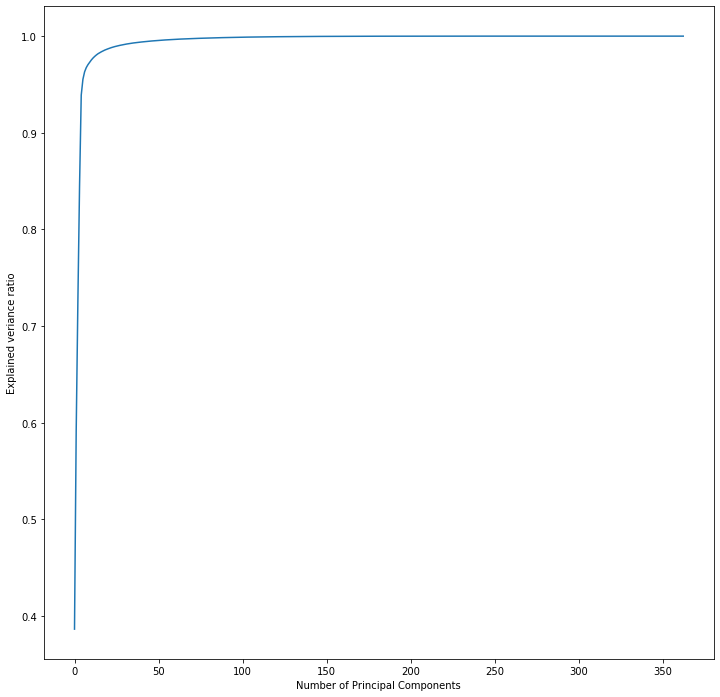

In [116]:
plt.figure(figsize=(12,12))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Principal Components")
plt.ylabel("Explained veriance ratio")

In [117]:
pca1 = PCA(n_components=45)

In [118]:
X_train_pca_df = pd.DataFrame(pca1.fit_transform(X_train), columns=list(range(0,45)))
X_test_pca_df =  pd.DataFrame(pca1.transform(X_test))

In [119]:
X_train_pca_df

0          1          2          3          4         5   \
0     -1.544289  -0.824992   2.843841  -2.544883   1.313584 -4.510989   
1     -9.959137   2.312521  -5.690243  16.131003  -4.432750 -2.355228   
2      2.638594  -1.888735   6.522407 -14.471979  -7.173325 -2.281573   
3     28.545711  14.048909  -5.890521   8.691848  -2.105240 -2.068995   
4     -2.263481  -8.139869  11.287388   4.394998 -12.202797  0.357330   
...         ...        ...        ...        ...        ...       ...   
3350 -14.219149  -6.974966   4.092569 -10.268049  -7.130547  0.910125   
3351   0.552702  16.452711   0.200888   9.764205 -10.341630 -4.134721   
3352  -9.193261   1.516230  13.556272   9.754312  -2.245289 -1.547189   
3353 -14.002240  11.481141  10.546388  -5.651545  -2.751973 -1.785202   
3354  -8.593283  17.335740 -10.253766  -3.075604   3.936105 -0.428898   

            6         7         8         9         10        11        12  \
0     1.497924 -1.848113  2.373872 -0.227971 -1.036275 -0.539821 -0.364789   
1    -0.752267 -2.927850 -0.955590  0.079541 -0.124049  0.271745 -0.429909   
2     0.788575 -1.923893  1.651099 -0.561468 -0.534815  0.374968 -1.352893   
3     1.128292 -0.324627 -0.761757 -0.789634  1.633669 -0.576225  1.355751   
4    -2.664678  0.129632 -0.518654 -0.660244  0.053999 -0.402659  0.600631   
...        ...       ...       ...       ...       ...       ...       ...   
3350 -2.759280  1.676623 -1.895373  1.155819  1.379139 -0.230294 -1.285763   
3351  1.136563  0.721318 -1.382320 -1.017498  0.900492 -0.738193  0.557065   
3352  1.431038 -1.824192 -1.683107  1.508861 -0.261283  0.912092 -1.048901   
3353 -1.588163 -0.468043 -0.513397 -0.286633 -0.127733  0.417873  0.319219   
3354 -0.303729  1.079620 -1.451576  0.401471  2.079772 -0.448212  0.331674   

            13        14        15        16        17        18        19  \
0    -0.873245  1.028270  0.284276  0.087572  0.058755  0.663960 -1.168575   
1    -0.377660  0.436714  0.157337 -0.939837  0.660518  0.523079 -0.391293   
2     0.309197 -0.471445  0.084420 -0.212422 -0.024082 -0.304529  0.294787   
3    -0.549355  1.015349  2.146519 -0.432140 -0.589044 -0.127133  0.449501   
4    -0.142732  1.218818  0.477372 -0.553137  0.146678  0.300462  0.316426   
...        ...       ...       ...       ...       ...       ...       ...   
3350 -1.476808  1.656284  0.186906  0.310823  0.439519  0.061619 -0.920984   
3351  0.835136 -0.345809 -0.541694  0.097207  0.850524  0.717571  0.664224   
3352  0.129092 -0.224621 -0.201628 -0.797789  0.618327  1.719758  1.389927   
3353 -1.601676 -0.355852  0.949776  1.321055 -0.466218  0.004641  0.215164   
3354 -0.368228 -0.230561 -0.612628  0.269748  0.421770  1.235473  0.531933   

            20        21        22        23        24        25        26  \
0    -0.508609  0.590425 -0.746908 -0.419889  0.270636  0.157029 -0.098002   
1     0.715742 -0.990164  0.508792 -0.129086  0.261061 -0.515424 -0.066966   
2     1.086411 -0.627664  0.396498  0.138865 -0.196387 -0.535898  0.735128   
3     0.197901 -0.624637 -0.059979  0.319716  0.766709 -0.512455  0.044984   
4    -0.650139 -1.395237 -0.994617  0.009620 -0.861662 -0.113301  0.545113   
...        ...       ...       ...       ...       ...       ...       ...   
3350  0.296011  0.566233 -0.368864 -0.128431 -0.068481 -0.224142  0.179680   
3351  0.485868  0.492898 -0.655621 -1.137240 -0.988206  0.344255 -0.367984   
3352 -0.084604 -0.321313  0.942550  0.510260 -0.626927 -0.090412 -0.782680   
3353 -0.124897 -0.929571  1.170636  0.056090 -0.360790  0.269138  0.275971   
3354 -0.595122  0.423270  0.252607 -0.956349  0.562786 -0.073424  0.096601   

            27        28        29        30        31        32        33  \
0     0.130397  0.328758  0.172485  0.265257  0.549017 -0.145111 -0.081533   
1    -0.263788 -0.049874 -0.261616  0.103626 -0.282623 -0.308384 -0.085651   
2     0.303894 -0.492485 -0.880517  0.149027 -0.199209  0.132673  0.216160   
3     0.23650

In [120]:
columns = []
print ("cName","\t", "PearSon Coree","\t\t", "pvalue","\n")
for col in X_train_pca_df.columns:
    corre, pvalue = stats.pearsonr(X_train_pca_df[col], y_train)
    
    if (pvalue < 0.03):
        print (col,"\t", corre*100,"\t", pvalue)
        columns.append(col)
print("\n No of PCAs Highly Correlate with Target Veriable: ==>:", len(columns), "Outof_Available PCAs",X_train_pca_df.shape[1])

cName 	 PearSon Coree 		 pvalue 

0 	 19.476964092350325 	 4.880761112687273e-30
2 	 -7.23061337803006 	 2.7642176841138013e-05
3 	 -8.093504631002178 	 2.680400243445476e-06
6 	 18.344086737234452 	 8.903178851827968e-27
7 	 -34.57372734458168 	 8.127118222939264e-95
9 	 31.093072670774436 	 4.1256359312919345e-76
10 	 -11.316131364364846 	 4.9228326474586266e-11
11 	 -29.876905090696603 	 3.8452100198525876e-70
12 	 11.941213753789302 	 3.951765431751376e-12
13 	 -16.01185789527532 	 1.0462584386715168e-20
14 	 3.753159593419725 	 0.029714564513471254
15 	 14.896204879766747 	 4.192208847501762e-18
16 	 -33.09368859024604 	 1.4586659568641882e-86
17 	 6.316464929693377 	 0.000251293339807451
19 	 3.9411050761613495 	 0.02244113003210641
20 	 6.758007268382246 	 8.950261964474766e-05
21 	 6.2876699816973876 	 0.0002682082203906298
22 	 6.440725822601645 	 0.00018913248021543312
24 	 -3.980860703617737 	 0.021118272734975706
25 	 4.482145780419756 	 0.009417832369759061
32 	 -8.9739592

In [121]:
X_train_pca_df_final = X_train_pca_df[columns]
X_test_pca_df_final = X_test_pca_df[columns]

In [122]:
mMS = MinMaxScaler()

In [123]:
for col in X_test_pca_df_final.columns:
    X_train_pca_df_final[col] = mMS.fit_transform(np.array(X_train_pca_df_final[col]).reshape(-1,1))
    X_test_pca_df_final[col] = mMS.transform(np.array(X_test_pca_df_final[col]).reshape(-1,1))

In [124]:
def model_Execute(xtrain, xtest, ytrain, ytest, model):
    obj = model
    obj.fit(xtrain, ytrain)
    y_predict = obj.predict(xtest)
    y_predict_train = obj.predict(xtrain)
    
    test_r2_score = r2_score(ytest, y_predict)
    train_r2_score = r2_score(ytrain, y_predict_train)
    print(str(obj).split("(")[0])
    print("Train Accuracy(R2 Score): ===========>", train_r2_score)
    print("Test Accuracuy(R2 Score): ===========>", test_r2_score)
    print("MeanSquareError: ====================>", mean_squared_error(ytest, y_predict))
    print("RootMeanSquareError: ================>", np.sqrt(mean_squared_error(ytest, y_predict)), "\n")

In [125]:
models = {
    'lr': LinearRegression(),
    'dt': DecisionTreeRegressor(),
    'rf': RandomForestRegressor(),
    'agb': AdaBoostRegressor(),
    'gbr': GradientBoostingRegressor()
}

In [126]:
for mName, Model in models.items():
    model_Execute(X_train_pca_df_final, X_test_pca_df_final, y_train, y_test, Model)

LinearRegression
Train Accuracy(R2 Score): ===========> 0.604518511440505
Test Accuracuy(R2 Score): ===========> 0.6337437388455567
MeanSquareError: ====================> 0.005347807288918421
RootMeanSquareError: ================> 0.07312870359112365 

DecisionTreeRegressor
Train Accuracy(R2 Score): ===========> 0.9775554769646672
Test Accuracuy(R2 Score): ===========> 0.3255619071883816
MeanSquareError: ====================> 0.009847654036803773
RootMeanSquareError: ================> 0.0992353467107551 

RandomForestRegressor
Train Accuracy(R2 Score): ===========> 0.9226489846390744
Test Accuracuy(R2 Score): ===========> 0.6058184152382553
MeanSquareError: ====================> 0.005755552534451733
RootMeanSquareError: ================> 0.07586535793398547 

AdaBoostRegressor
Train Accuracy(R2 Score): ===========> 0.23599047916621552
Test Accuracuy(R2 Score): ===========> 0.20378845689679248
MeanSquareError: ====================> 0.011625701306257816
RootMeanSquareError: =============

## Linear Regression Model

In [29]:
linRig = LinearRegression()
linRig.fit(X_train_pca_df_final, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [30]:
y_predict_linRig = linRig.predict(X_test_pca_df_final)

print("Train Accuracy(R2 Score): ===========>", linRig.score(X_train_pca_df_final, y_train), "\n")
print("Test Accuracuy(R2 Score): ===========>", linRig.score(X_test_pca_df_final, y_test), "\n")

print("MeanSquareError: ====================>", mean_squared_error(y_test, y_predict_linRig), "\n")
print("RootMeanSquareError: ================>", np.sqrt(mean_squared_error(y_test, y_predict_linRig)))

Train Accuracy(R2 Score): ===========> 0.6060800238253873 

Test Accuracuy(R2 Score): ===========> 0.6365124683216239 

MeanSquareError: ====================> 0.005307380316758313 

RootMeanSquareError: ================> 0.07285176948268526


## HyperParameter

In [174]:
adbR = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), random_state=2020)

In [178]:
adbR_params = {
    'n_estimators': np.arange(5, 200, 5),
    'learning_rate': np.linspace(0.0001, 1, 15),
    'loss': ['linear', 'square', 'exponential'],
    "base_estimator__criterion" : ["friedman_mse", "mse"],
    "base_estimator__min_samples_split": np.arange(1, 20, 1),
    "base_estimator__min_samples_leaf": np.arange(1, 20, 1),
    "base_estimator__max_depth" : np.arange(1, 20, 1)
}

In [179]:
rsCV = RandomizedSearchCV(estimator=adbR, param_distributions=adbR_params, scoring='r2', n_jobs=-1, n_iter=200)

In [180]:
rsCV.fit(X_train_pca_df_final, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                                                    criterion='mse',
                                                                                    max_depth=None,
                                                                                    max_features=None,
                                                                                    max_leaf_nodes=None,
                                                                                    min_impurity_decrease=0.0,
                                                                                    min_impurity_split=None,
                                                                                    min_samples_leaf=1,
                                                                                    min_samples_split=2,
                  

In [185]:
best_model = rsCV.best_estimator_

In [186]:
best_model.fit(X_train_pca_df_final, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=11,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=6,
                                                       min_samples_split=7,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
                 

In [187]:
model_Execute(X_train_pca_df_final, X_test_pca_df_final, y_train, y_test, best_model)

AdaBoostRegressor
Train Accuracy(R2 Score): ===========> 0.8350195249592972
Test Accuracuy(R2 Score): ===========> 0.6253974406515722
MeanSquareError: ====================> 0.005469673858998583
RootMeanSquareError: ================> 0.07395724345186604 



## Ensemble_Boosting ===> [GradientBoostingRegressor Model]

In [49]:
gbR = GradientBoostingRegressor()
gbR.fit(X_train_pca_df_final, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [51]:
y_predict_gbR = gbR.predict(X_test_pca_df_final)


# initially overfitted after tunning R2 = 0.52

print("Train Accuracy(R2 Score): ===========>", gbR.score(X_train_pca_df_final, y_train), "\n")
print("Test Accuracuy(R2 Score): ===========>", gbR.score(X_test_pca_df_final, y_test), "\n")

print("MeanSquareError: ====================>", mean_squared_error(y_test, y_predict_gbR), "\n")
print("RootMeanSquareError: ================>", np.sqrt(mean_squared_error(y_test, y_predict_gbR)))

Train Accuracy(R2 Score): ===========> 0.6975576486786084 

Test Accuracuy(R2 Score): ===========> 0.6201671823812012 

MeanSquareError: ====================> 0.005546042282607379 

RootMeanSquareError: ================> 0.07447175493170131


## Before Hyper ParameterTuning

In [57]:
gbR = GradientBoostingRegressor()

In [59]:
score = make_scorer(r2_score)

In [62]:
gbCV = cross_val_score(gbR, cv=5, X=X_train_pca_df_final, y=y_train, scoring=score)

In [63]:
gbCV.mean()

0.5837844259827183

In [64]:
gbR.fit(X_train_pca_df_final, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [65]:
train_pre = gbR.predict(X_train_pca_df_final)

In [66]:
test_pre = gbR.predict(X_test_pca_df_final)

In [67]:
r2_score(y_train, train_pre)

0.6975576486786087

In [68]:
r2_score(y_test, test_pre)

0.620308424106651

## After HyperParameter Tuning

In [74]:
gbR_hyp = GradientBoostingRegressor(random_state=42)

In [75]:
gbr_params = {
    'learning_rate': [0.001, 0.01, 0.1],
    'loss': ['ls', 'lad', 'huber'],
    'max_depth': [2, 3, 4, 5],
    'min_samples_leaf': np.arange(1, 8),
    'n_estimators': [5, 10, 15, 20],
    'tol': [0.0001, 0.001, 0.01, 0.1]
}

score = make_scorer(r2_score)

In [76]:
gbr_rsCV = RandomizedSearchCV(gbR_hyp, param_distributions=gbr_params, scoring=score, random_state=42)

In [77]:
gbr_rsCV.fit(X_train_pca_df_final, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                          

In [78]:
gbr_hyp_best = gbr_rsCV.best_estimator_

In [ ]:
gbr_hyp_best.bes

In [79]:
gbr_hyp_best.fit(X_train_pca_df_final, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='huber',
                          max_depth=3, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=20,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [181]:
gbrcv_scores = cross_val_score(gbr_hyp_best, X=X_train_pca_df_final, y=y_train, scoring='r2')

In [91]:
gbrcv_scores.mean()

0.5221947029942126

In [92]:
gbr_hyp_best.score(X_train_pca_df_final, y_train)

0.5429821082581806

In [93]:
gbr_hyp_best.score(X_test_pca_df_final, y_test)

0.5755589693025854

In [60]:
svrR = SVR(kernel='poly', degree=3, C=2, gamma=0.5)
svrR.fit(X_train_pca_df_final, y_train)
svrR.score(X_test_pca_df_final, y_test)

0.5564674384727663

In [61]:
y_predict_svrR = svrR.predict(X_test_pca_df_final)


# initially overfitted after tunning R2 = 0.52

print("Train Accuracy(R2 Score): ===========>", svrR.score(X_train_pca_df_final, y_train), "\n")
print("Test Accuracuy(R2 Score): ===========>", svrR.score(X_test_pca_df_final, y_test), "\n")

print("MeanSquareError: ====================>", mean_squared_error(y_test, y_predict_svrR), "\n")
print("RootMeanSquareError: ================>", np.sqrt(mean_squared_error(y_test, y_predict_svrR)))

Train Accuracy(R2 Score): ===========> 0.6114062164632249 

Test Accuracuy(R2 Score): ===========> 0.5564674384727663 

MeanSquareError: ====================> 0.006476139569414218 

RootMeanSquareError: ================> 0.08047446532543237


In [62]:
models = {
           'LR': LinearRegression(), 
          'DTR': DecisionTreeRegressor(), 
          'RFS': RandomForestRegressor(), 
          'ADB': AdaBoostRegressor()
         }

In [63]:
for mName, model in models.items():
    obj = models[mName]
    obj.fit(X_train_pca_df, y_train)
    y_predict = obj.predict(X_test_pca_df)
    
    train_acc = obj.score(X_train_pca_df, y_train)
    test_acc =  obj.score(X_test_pca_df, y_test)
    
    R2Square = r2_score(y_test, y_predict)
    MSquareE = mean_squared_error(y_test, y_predict)
    
    print("\n\n")
    print("{} Model TrainAcc: ====>{} TestAccuracy          : ====>{}".format(mName, train_acc, test_acc))
    print("{} Model R2 Score: ====>{} Model MeanSquare Error: ====>{}".format(mName, R2Square, MSquareE))




LR Model TrainAcc: ====>0.6112955965847053 TestAccuracy          : ====>0.6404050652958228
LR Model R2 Score: ====>0.6404050652958228 Model MeanSquare Error: ====>0.005250543449571858



DTR Model TrainAcc: ====>0.977555457783147 TestAccuracy          : ====>0.2622579467356776
DTR Model R2 Score: ====>0.2622579467356776 Model MeanSquare Error: ====>0.01077197238172244



RFS Model TrainAcc: ====>0.9222606060810147 TestAccuracy          : ====>0.613283547745761
RFS Model R2 Score: ====>0.613283547745761 Model MeanSquare Error: ====>0.005646552104232339



ADB Model TrainAcc: ====>0.2648100213796104 TestAccuracy          : ====>0.23480173084074052
ADB Model R2 Score: ====>0.23480173084074052 Model MeanSquare Error: ====>0.011172868057952657
